Step 1: Load the Data which is prepared from the nuscenes dataset

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from pyquaternion import Quaternion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [23]:
# Load the Excel file
df = pd.read_excel('Filtered_PCD_Annotations_AB.xlsx')


In [24]:
print(df.columns.tolist())

['a_sample_token', 'a_x_global', 'a_y_global', 'a_z_global', 'a_radar_token', 'a_radar_x', 'a_radar_y', 'a_radar_z', 'a_radar_cam_x', 'a_radar_cam_y', 'a_radar_cam_z', 'a_dyn_prop', 'a_cluster_id', 'a_rcs', 'a_vx', 'a_vy', 'a_vx_comp', 'a_vy_comp', 'a_is_quality_valid', 'a_ambig_state', 'a_x_rms', 'a_y_rms', 'a_invalid_state', 'a_pdh0', 'a_vx_rms', 'a_vy_rms', 'a_image_coord_x', 'a_image_coord_y', 'a_depth', 'a_depth_patch', 'a_scene_name', 'a_scene_token', 'a_timestamp', 'a_annotation_token', 'a_category', 'a_instance_token', 'a_center_x', 'a_center_y', 'a_center_z', 'a_length', 'a_width', 'a_height', 'a_rotation_w', 'a_rotation_x', 'a_rotation_y', 'a_rotation_z', 'a_yaw', 'a_num_lidar_pts', 'a_num_radar_pts', 'a_distance', 'a_can_timestamp', 'a_brake', 'a_brake_switch', 'a_rear_left_rpm', 'a_rear_right_rpm', 'a_can_utime', 'a_vehicle_speed', 'a_yaw_rate', 'a_next_token', 'a_radar_pcd_file', 'a_image_file', 'a_camera_pose_x', 'a_camera_pose_y', 'a_camera_pose_z', 'b_sample_token', 'b_

In [72]:
df_eda = df.copy()
df_eda = df_eda[[
    'a_center_x', 'a_center_y', 'a_center_z',
    'b_center_x', 'b_center_y', 'b_center_z',
    'a_length', 'a_width', 'a_height', 
    'b_length', 'b_width', 'b_height',
    'a_rotation_w', 'a_rotation_x', 'a_rotation_y', 'a_rotation_z', 
    'b_rotation_w', 'b_rotation_x', 'b_rotation_y', 'b_rotation_z', 
    'a_distance', 
    'b_distance', 
    'a_yaw',
    'a_brake', 'a_brake_switch', 'a_rear_left_rpm', 'a_rear_right_rpm', 'a_vehicle_speed', 'a_yaw_rate',
    'b_brake', 'b_brake_switch', 'b_rear_left_rpm', 'b_rear_right_rpm', 'b_vehicle_speed', 'b_yaw_rate',
    'a_image_coord_x', 'a_image_coord_y', 
    'b_image_coord_x', 'b_image_coord_y', 
    'a_depth', 
    'b_depth',
    'a_radar_x', 'a_radar_y', 
    'a_vx', 'a_vy']]

In [73]:
# Translation deltas
df_eda['delta_center_x'] = df_eda['b_center_x'] - df_eda['a_center_x']
df_eda['delta_center_y'] = df_eda['b_center_y'] - df_eda['a_center_y']
df_eda['delta_center_z'] = df_eda['b_center_z'] - df_eda['a_center_z']
df_eda['delta_length'] = df_eda['b_length'] - df_eda['a_length']
df_eda['delta_width'] = df_eda['b_width'] - df_eda['a_width']
df_eda['delta_height'] = df_eda['b_height'] - df_eda['a_height']
df_eda['delta_vehicle_speed'] = df_eda['b_vehicle_speed'] - df_eda['a_vehicle_speed']

def compute_delta_quaternion(row):
    q1 = Quaternion([row['a_rotation_w'], 0.0, 0.0, row['a_rotation_z']])
    q2 = Quaternion([row['b_rotation_w'], 0.0, 0.0, row['b_rotation_z']])
    delta_q = q2 * q1.inverse
    return pd.Series({
        'delta_rotation_w': delta_q.w,
        'delta_rotation_x': delta_q.x,
        'delta_rotation_y': delta_q.y,
        'delta_rotation_z': delta_q.z
    })

df_quat = df_eda.apply(compute_delta_quaternion, axis=1)
df_eda = pd.concat([df_eda, df_quat], axis=1)

df_eda = df_eda.drop(['b_center_x', 'b_center_y', 'b_center_z','b_length', 'b_width', 'b_height','b_rotation_w', 'b_rotation_x', 'b_rotation_y', 'b_rotation_z', 'b_distance', 'b_brake', 'b_brake_switch', 'b_rear_left_rpm', 'b_rear_right_rpm', 'b_vehicle_speed', 'b_yaw_rate','b_image_coord_x', 'b_image_coord_y'], axis=1)  # Add any columns to drop if necessary

df_eda = df_eda.loc[:, df_eda.nunique() > 1]

In [74]:
corr_matrix = df_eda.corr()

# Step 2: Get absolute correlations with 'a_radar_x'
corr_with_radar_x = corr_matrix['a_radar_x'].abs()
corr_with_radar_y = corr_matrix['a_radar_y'].abs()
corr_with_radar_vx = corr_matrix['a_vx'].abs()
corr_with_radar_vy = corr_matrix['a_vy'].abs()

# Step 3: Drop self-correlation
corr_with_radar_x = corr_with_radar_x.drop(['a_radar_y', 'a_vx', 'a_vy'])
corr_with_radar_y = corr_with_radar_y.drop(['a_radar_x', 'a_vx', 'a_vy'])
#'a_rear_left_rpm', 'a_rear_right_rpm' dropped because of high correlation with vehicle_speed
corr_with_radar_vx = corr_with_radar_vx.drop(['a_radar_x', 'a_radar_y', 'a_vy', 'a_rear_left_rpm', 'a_rear_right_rpm']) 
corr_with_radar_vy = corr_with_radar_vy.drop(['a_radar_x', 'a_radar_x', 'a_vx'])

# Step 4: Compute threshold for top 50%
threshold_x = corr_with_radar_x.quantile(0.70)
threshold_y = corr_with_radar_y.quantile(0.70)
threshold_vx = corr_with_radar_vx.quantile(0.70)
threshold_vy = corr_with_radar_vy.quantile(0.70)


# Step 5: Select columns above threshold
top_corr_columns_x = corr_with_radar_x[corr_with_radar_x >= threshold_x].index.tolist()
top_corr_columns_y = corr_with_radar_y[corr_with_radar_y >= threshold_y].index.tolist()
top_corr_columns_vx = corr_with_radar_vx[corr_with_radar_vx >= threshold_vx].index.tolist()
top_corr_columns_vy = corr_with_radar_vy[corr_with_radar_vy >= threshold_vy].index.tolist()


# Step 6: Filter the DataFrame
df_top_corr_x = df_eda[top_corr_columns_x]
df_top_corr_y = df_eda[top_corr_columns_y]
df_top_corr_vx = df_eda[top_corr_columns_vx]
df_top_corr_vy = df_eda[top_corr_columns_vy]


In [75]:
top_corr_columns_x

['a_center_x',
 'a_center_z',
 'a_length',
 'a_image_coord_y',
 'a_depth',
 'b_depth',
 'a_radar_x',
 'delta_center_x']

In [76]:
top_corr_columns_y

['a_center_x',
 'a_rotation_w',
 'a_rotation_z',
 'a_yaw',
 'a_image_coord_x',
 'a_image_coord_y',
 'a_radar_y',
 'delta_vehicle_speed']

In [77]:
top_corr_columns_vx

['a_center_y',
 'a_yaw',
 'a_brake',
 'a_brake_switch',
 'a_vehicle_speed',
 'a_vx',
 'delta_center_x',
 'delta_center_y']

In [78]:
top_corr_columns_vy

['a_center_y',
 'a_length',
 'a_width',
 'a_brake',
 'a_brake_switch',
 'a_yaw_rate',
 'a_depth',
 'a_vy',
 'delta_vehicle_speed']

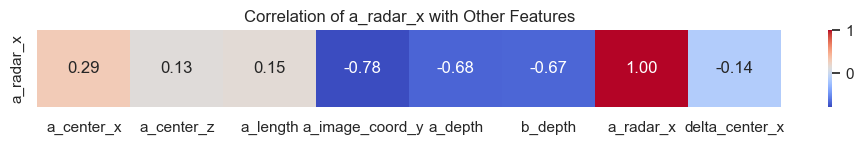

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df_top_corr_x.corr()

# Extract correlations for a_radar_x
radar_x_corr = corr_matrix.loc[['a_radar_x']]

# Plot heatmap
plt.figure(figsize=(12, 1))  # Wide and short for horizontal heatmap
sns.heatmap(radar_x_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation of a_radar_x with Other Features")
plt.show()

C:\Users\dilip\AppData\Local\Temp\ipykernel_23300\2999319696.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=radar_x_corr.values, y=radar_x_corr.index, palette="coolwarm")


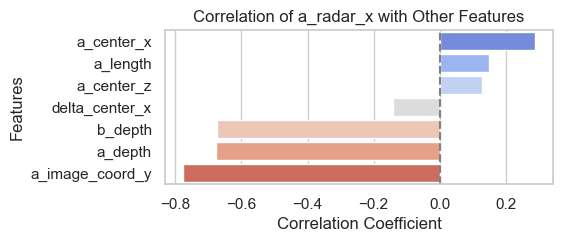

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df_top_corr_x.corr()

# Extract and sort correlations for a_radar_x (excluding self-correlation)
radar_x_corr = corr_matrix['a_radar_x'].drop('a_radar_x').sort_values(ascending=False)

# Plot bar chart
plt.figure(figsize=(5, 2))
sns.barplot(x=radar_x_corr.values, y=radar_x_corr.index, palette="coolwarm")
plt.title("Correlation of a_radar_x with Other Features")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.axvline(0, color='gray', linestyle='--')
plt.show()

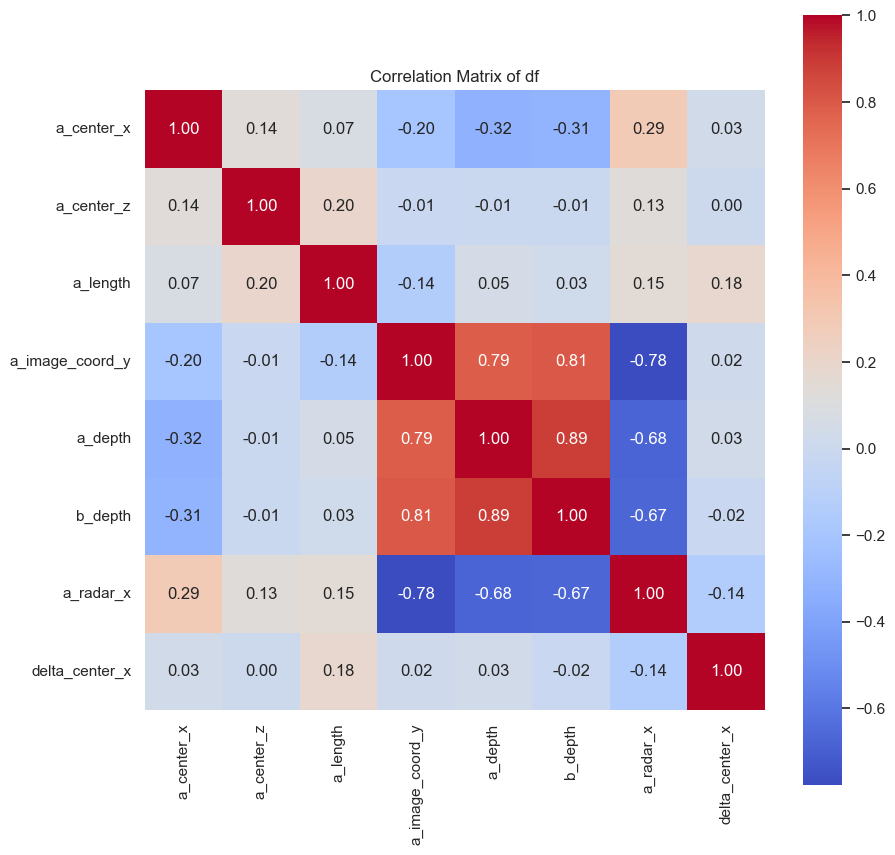

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_top_corr_x.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of df")
plt.show()

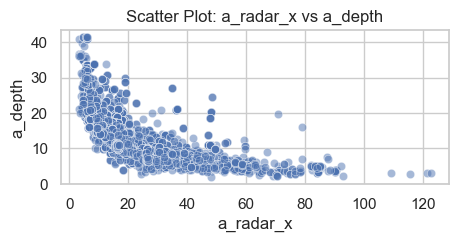

In [46]:
plt.figure(figsize=(5, 2))
sns.scatterplot(x=df_eda['a_radar_x'], y=df_eda['a_depth'], alpha=0.5)
plt.xlabel('a_radar_x')
plt.ylabel('a_depth')
plt.title('Scatter Plot: a_radar_x vs a_depth')
plt.show()

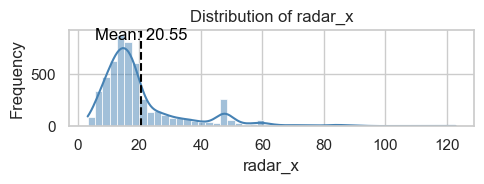

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Compute means
mean_radar_x = df_eda['a_radar_x'].mean()
mean_radar_y = df_eda['a_radar_y'].mean()
mean_radar_vx = df_eda['a_vx'].mean()
mean_radar_vy = df_eda['a_vy'].mean()
mean_depth = df_eda['a_depth'].mean()

# Create a single subplot
fig, ax = plt.subplots(figsize=(5, 2))

# Histogram for radar_x
sns.histplot(df_eda['a_radar_x'], bins=50, kde=True, ax=ax, color='steelblue')
ax.axvline(mean_radar_x, color='black', linestyle='--', linewidth=1.5)
ax.text(mean_radar_x, ax.get_ylim()[1]*0.9, f'Mean: {mean_radar_x:.2f}', color='black', ha='center')
ax.set_title('Distribution of radar_x')
ax.set_xlabel('radar_x')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


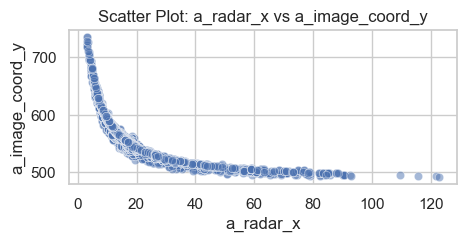

In [45]:
plt.figure(figsize=(5, 2))
sns.scatterplot(x=df_eda['a_radar_x'], y=df_eda['a_image_coord_y'], alpha=0.5)
plt.xlabel('a_radar_x')
plt.ylabel('a_image_coord_y')
plt.title('Scatter Plot: a_radar_x vs a_image_coord_y')
plt.show()

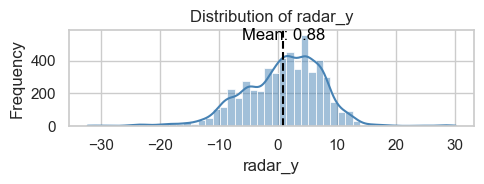

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Compute means
mean_radar_x = df_eda['a_radar_x'].mean()
mean_radar_y = df_eda['a_radar_y'].mean()
mean_radar_vx = df_eda['a_vx'].mean()
mean_radar_vy = df_eda['a_vy'].mean()
mean_depth = df_eda['a_depth'].mean()

# Create a single subplot
fig, ax = plt.subplots(figsize=(5, 2))

# Histogram for radar_x
sns.histplot(df_eda['a_radar_y'], bins=50, kde=True, ax=ax, color='steelblue')
ax.axvline(mean_radar_y, color='black', linestyle='--', linewidth=1.5)
ax.text(mean_radar_y, ax.get_ylim()[1]*0.9, f'Mean: {mean_radar_y:.2f}', color='black', ha='center')
ax.set_title('Distribution of radar_y')
ax.set_xlabel('radar_y')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


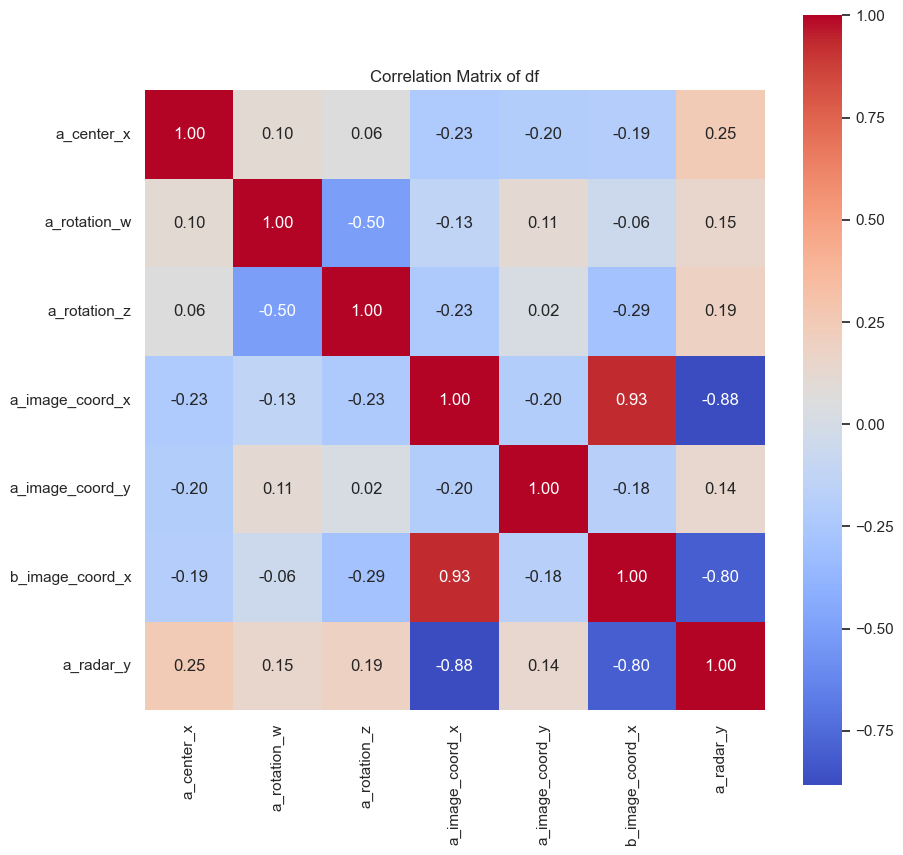

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_top_corr_y.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of df")
plt.show()

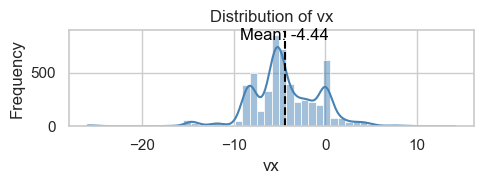

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Compute means
mean_radar_x = df_eda['a_radar_x'].mean()
mean_radar_y = df_eda['a_radar_y'].mean()
mean_radar_vx = df_eda['a_vx'].mean()
mean_radar_vy = df_eda['a_vy'].mean()
mean_depth = df_eda['a_depth'].mean()

# Create a single subplot
fig, ax = plt.subplots(figsize=(5, 2))

# Histogram for radar_x
sns.histplot(df_eda['a_vx'], bins=50, kde=True, ax=ax, color='steelblue')
ax.axvline(mean_radar_vx, color='black', linestyle='--', linewidth=1.5)
ax.text(mean_radar_vx, ax.get_ylim()[1]*0.9, f'Mean: {mean_radar_vx:.2f}', color='black', ha='center')
ax.set_title('Distribution of vx')
ax.set_xlabel('vx')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

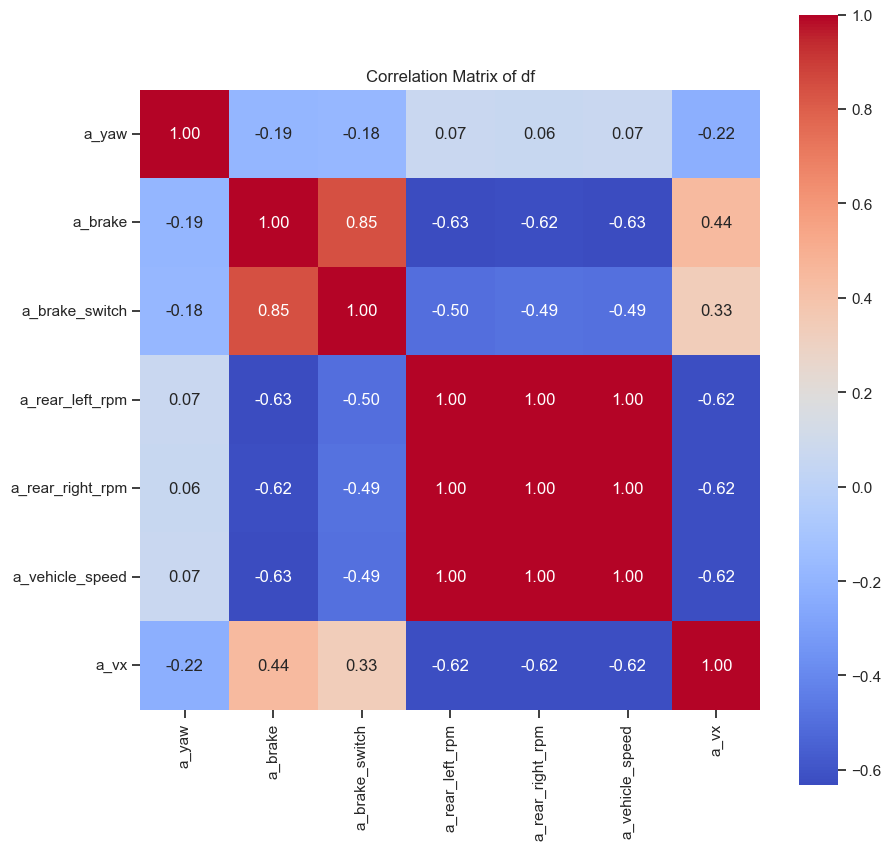

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_top_corr_vx.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of df")
plt.show()

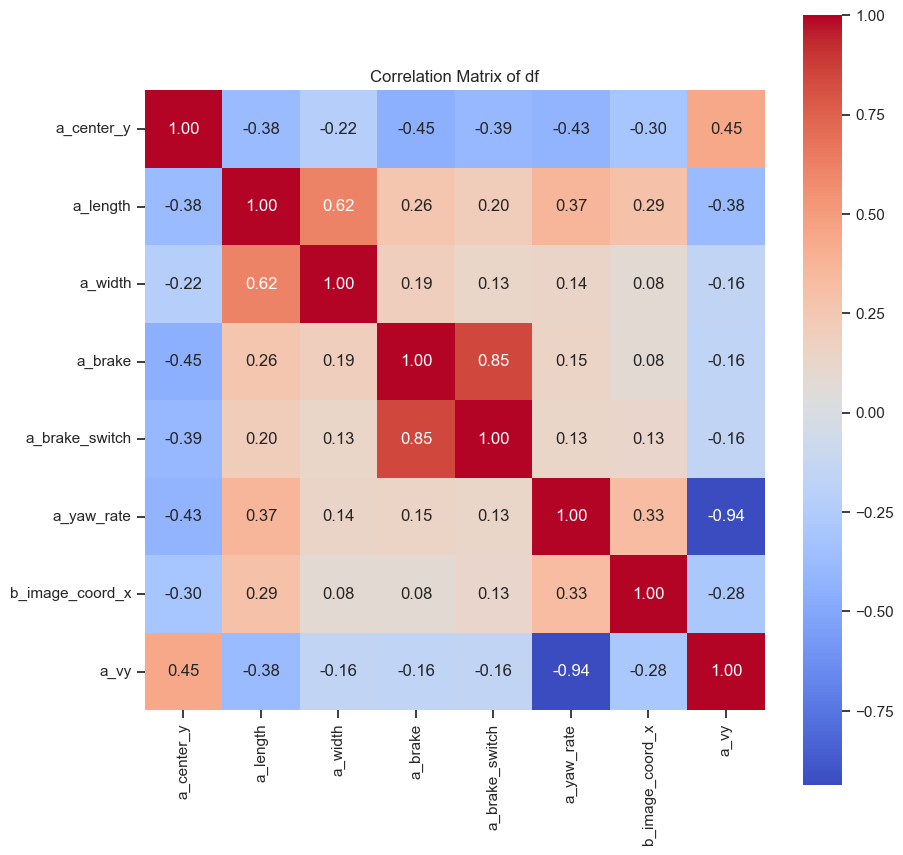

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_top_corr_vy.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of df")
plt.show()

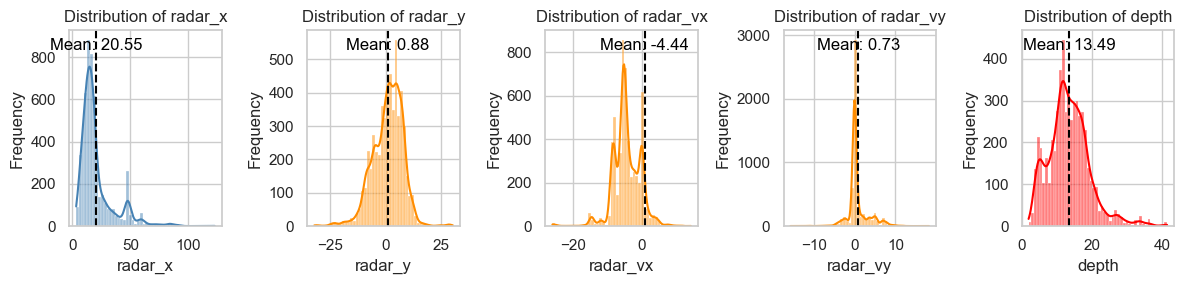

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Compute means
mean_radar_x = df_eda['a_radar_x'].mean()
mean_radar_y = df_eda['a_radar_y'].mean()
mean_radar_vx = df_eda['a_vx'].mean()
mean_radar_vy = df_eda['a_vy'].mean()
mean_depth = df_eda['a_depth'].mean()

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(12, 3))

# Histogram for radar_x
sns.histplot(df_eda['a_radar_x'], bins=50, kde=True, ax=axes[0], color='steelblue')
axes[0].axvline(mean_radar_x, color='black', linestyle='--', linewidth=1.5)
axes[0].text(mean_radar_x, axes[0].get_ylim()[1]*0.9, f'Mean: {mean_radar_x:.2f}', color='black', ha='center')
axes[0].set_title('Distribution of radar_x')
axes[0].set_xlabel('radar_x')
axes[0].set_ylabel('Frequency')

# Histogram for a_radar_y
sns.histplot(df_eda['a_radar_y'], bins=50, kde=True, ax=axes[1], color='darkorange')
axes[1].axvline(mean_radar_y, color='black', linestyle='--', linewidth=1.5)
axes[1].text(mean_radar_y, axes[1].get_ylim()[1]*0.9, f'Mean: {mean_radar_y:.2f}', color='black', ha='center')
axes[1].set_title('Distribution of radar_y')
axes[1].set_xlabel('radar_y')
axes[1].set_ylabel('Frequency')

# Histogram for a_radar_vx
sns.histplot(df_eda['a_vx'], bins=50, kde=True, ax=axes[2], color='darkorange')
axes[2].axvline(mean_radar_y, color='black', linestyle='--', linewidth=1.5)
axes[2].text(mean_radar_y, axes[2].get_ylim()[1]*0.9, f'Mean: {mean_radar_vx:.2f}', color='black', ha='center')
axes[2].set_title('Distribution of radar_vx')
axes[2].set_xlabel('radar_vx')
axes[2].set_ylabel('Frequency')


# Histogram for a_radar_vy
sns.histplot(df_eda['a_vy'], bins=50, kde=True, ax=axes[3], color='darkorange')
axes[3].axvline(mean_radar_y, color='black', linestyle='--', linewidth=1.5)
axes[3].text(mean_radar_y, axes[3].get_ylim()[1]*0.9, f'Mean: {mean_radar_vy:.2f}', color='black', ha='center')
axes[3].set_title('Distribution of radar_vy')
axes[3].set_xlabel('radar_vy')
axes[3].set_ylabel('Frequency')


# Histogram for depth
sns.histplot(df_eda['a_depth'], bins=50, kde=True, ax=axes[4], color='red')
axes[4].axvline(mean_depth, color='black', linestyle='--', linewidth=1.5)
axes[4].text(mean_depth, axes[4].get_ylim()[1]*0.9, f'Mean: {mean_depth:.2f}', color='black', ha='center')
axes[4].set_title('Distribution of depth')
axes[4].set_xlabel('depth')
axes[4].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [38]:
df_pairplot = df_eda[['a_image_coord_x', 'a_image_coord_y', 'a_radar_x', 'a_radar_y', 'a_depth']].copy()
df_pairplot.shape

(5450, 5)

In [39]:
df_pairplot.sample(5)

,a_image_coord_x,a_image_coord_y,a_radar_x,a_radar_y,a_depth
5374,816.403315,527.575586,26.600000,0.1,6.984426
878,1043.462885,508.928364,37.200001,-6.1,8.495274
3196,716.305133,568.036354,12.800000,1.5,17.353323
780,1600.254141,700.653075,4.000000,-3.7,36.626896
5232,582.265051,628.492087,7.200000,1.7,29.958397


In [40]:
df_pairplot.dtypes

a_image_coord_x    float64
a_image_coord_y    float64
a_radar_x          float64
a_radar_y          float64
a_depth            float64
dtype: object

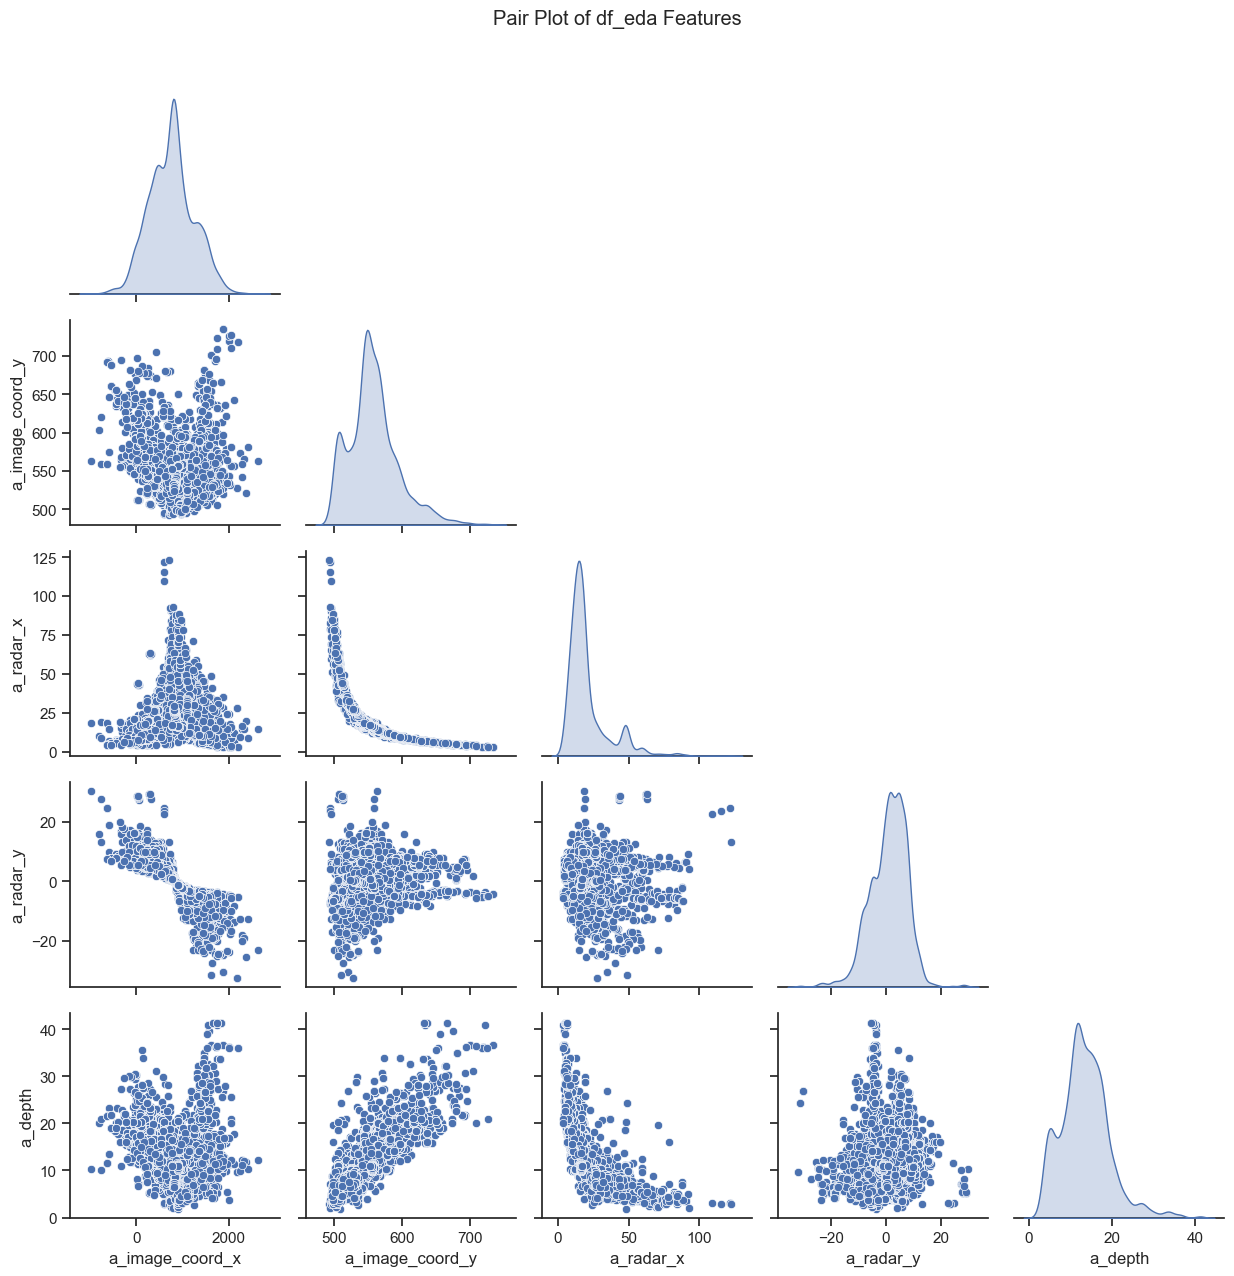

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot aesthetics
sns.set(style="ticks", color_codes=True)


# Generate pair plot
sns.pairplot(df_pairplot, diag_kind="kde", corner=True)

# Show the plot
plt.suptitle("Pair Plot of df_eda Features", y=1.02)
plt.tight_layout()
plt.show()